# TIC-HEAP Cirta Particle Classification Challenge

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from collections import Counter

In [2]:
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Load and pre-process the data

In [4]:
train_path = '../data/train/combined.pkl'
test_path = '../data/test/data_test_file.pkl'

In [5]:
with open(train_path, 'rb') as f:
    training_data = pkl.load(f)

In [6]:
classes2name = {11: 'electron', 13: 'muon', 211: 'pion', 321: 'kaon', 2212: 'proton'}
classes2int = {211:0, 321:1, 2212:2, 11:3, 13:4}

In [7]:
def show_images(data):
    fig = plt.figure(figsize=(25, 4))
    
    for i in np.arange(20):
        ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
        ax.imshow(data[0][i], cmap='gray')
        ax.set_title(classes2name[data[1][i]])

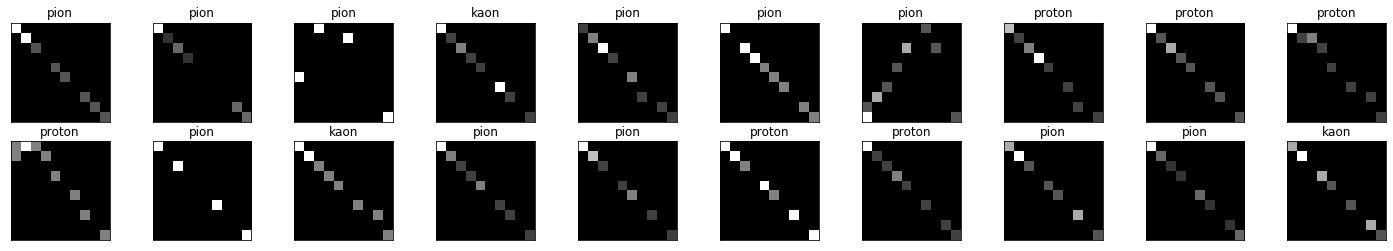

In [8]:
show_images(training_data)

## Distribution of data

In [9]:
counts = Counter(training_data[1])
counts

Counter({211: 906047, 321: 154323, 2212: 111730, 13: 1237, 11: 3138})

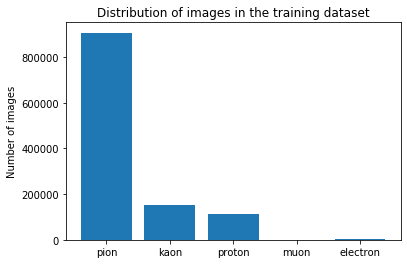

In [10]:
labels = [classes2name[i] for i in list(counts.keys())]

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), labels)
plt.ylabel('Number of images')
plt.title('Distribution of images in the training dataset')
plt.show()

# Undersample the classes with large number of images

**separate the classes**

In [11]:
pion, kaon, proton, muon, electron = [], [], [], [], []

In [12]:
for i in range(training_data.shape[1]):
    if training_data[1][i] == 211:
        pion.append(training_data[0][i])
    elif training_data[1][i] == 321:
        kaon.append(training_data[0][i])
    elif training_data[1][i] == 2212:
        proton.append(training_data[0][i])
    elif training_data[1][i] ==  13:
        muon.append(training_data[0][i])
    elif training_data[1][i] ==  11:
        electron.append(training_data[0][i])

**sanity check** 
Length of the individual list must be equal to the number of counts founds with the counter

In [13]:
len(pion), len(kaon), len(proton), len(muon), len(electron)

(906047, 154323, 111730, 1237, 3138)

**shuffle the images and select 2000 imges from each class with more than 2000 images**

In [14]:
pion = np.array(pion)
kaon = np.array(kaon)
proton = np.array(proton)
muon = np.array(muon)
electron = np.array(electron)

shuffle the images in place

In [15]:
np.random.shuffle(pion)
np.random.shuffle(kaon)
np.random.shuffle(proton)
np.random.shuffle(muon)
np.random.shuffle(electron)

select subset of images

In [16]:
pion_subset = pion[:2000]
kaon_subset = kaon[:2000]
proton_subset = proton[:2000]
electron_subset = electron[:2000]

combine the subsets

In [17]:
args = (pion_subset, kaon_subset, proton_subset, electron_subset, muon)

In [18]:
new_subset = np.concatenate(args)
new_subset.shape

(9237, 10, 10)

In [19]:
labels = [0] * 2000 + [1] * 2000 + [2] * 2000 + [3] * 2000 + [4] * 1237

In [20]:
labels = np.array(labels)

**normalize the images**

Mean subtraction removes the mean of the dataset form each data point. 

<!--Then we normalize by dividing each zero-centred dimension by its standard deviation. This makes convergence faster while training the network. -->

In [21]:
max, min = np.max(new_subset), np.min(new_subset)
max, min

(9.0, 0.0)

In [22]:
train_images = (new_subset - min) / (max - min)

In [23]:
print(f'After-> min value: {np.min(train_images)}  max value: {np.max(train_images)}')

After-> min value: 0.0  max value: 1.0


## Create dataset and dataloaders

In [24]:
train_images, train_labels = torch.from_numpy(train_images), torch.from_numpy(labels.astype(np.int64))

In [25]:
train_images = train_images[:, None, :, :] # insert empty dimension at the channels axis

In [26]:
train_dataset = TensorDataset(train_images, train_labels)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

## Model

In [28]:
class ResBlock(nn.Module):
    '''
    Defines a residual network layer
    '''
    def __init__(self, n_channels):
        super().__init__()
        
        # reflection padding is used instead of zero padding
        # this makes makes sure the output is  still the same size 
        # as the input 
        layers = [    nn.ReflectionPad2d(1),
                      nn.Conv2d(n_channels, n_channels, 3),
                      nn.InstanceNorm2d(n_channels),
                      nn.ReLU(inplace=True),
                      nn.ReflectionPad2d(1),
                      nn.Conv2d(n_channels, n_channels, 3),
                      nn.InstanceNorm2d(n_channels)   ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.model(x)
        return x + out

In [29]:
class Model(nn.Module):
    def __init__(self, n_res_blocks):
        super().__init__()
        
        conv_layers = []
        fc_layers = []
        
        conv_layers += [nn.Conv2d(1, 32, 3, stride=2, padding=1),
                  nn.BatchNorm2d(32),
                  nn.ReLU(inplace=True)]
        
        # residual blocks
        conv_layers += [ResBlock(32) for i in range(n_res_blocks)]
        
        conv_layers += [nn.Conv2d(32, 64, 3, stride=2, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True)]
        
        # add fully connected layer
        fc_layers += [nn.Linear(64 * 3 * 3, 512),
                  nn.ReLU(inplace=True)]
        
        fc_layers += [nn.Linear(512, 5),
                  nn.LogSoftmax(dim=1)]
                
        #self.drop = nn.Dropout()
        
        self.conv_layers = nn.Sequential(*conv_layers)
        self.fc_layers = nn.Sequential(*fc_layers)
    
    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(-1, 64 * 3 * 3)
        out = self.fc_layers(out)
        return out

In [30]:
model = Model(18)
model = model.to(device)

## Loss function and optimizer

In [31]:
criterion = nn.NLLLoss()

In [32]:
optimizer = optim.AdamW(model.parameters(), lr=0.01)

## Training loop

In [33]:
n_epochs = 1000
training_losses = []

In [34]:
for epoch in range(1, n_epochs + 1):
    running_train_loss = 0.0
    train_acc = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device, dtype=torch.float), labels.to(device)
        
        # zero out the gradients of the optimizer
        optimizer.zero_grad()
        # forward pass
        log_ps = model(images)
        # find the loss
        train_loss = criterion(log_ps, labels)
        # backpropagate
        train_loss.backward()
        optimizer.step()
        
        running_train_loss += train_loss.item()
        # find accuracy
        probs = torch.exp(log_ps)
        _, top_class = probs.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_acc += torch.mean(equals.type(torch.FloatTensor))
        
    else:
        if epoch%10==0:
            # print stats
            print(f'Epoch: {epoch}/{n_epochs} | Training loss: {running_train_loss/len(train_loader):.3f} | '
                  f'Accuracy: {train_acc/len(train_loader)*100:.3f}')

Epoch: 10/1000 | Training loss: 1.572 | Accuracy: 25.112
Epoch: 20/1000 | Training loss: 1.569 | Accuracy: 24.914
Epoch: 30/1000 | Training loss: 1.563 | Accuracy: 24.763
Epoch: 40/1000 | Training loss: 1.550 | Accuracy: 26.329
Epoch: 50/1000 | Training loss: 1.540 | Accuracy: 26.837
Epoch: 60/1000 | Training loss: 1.530 | Accuracy: 27.308
Epoch: 70/1000 | Training loss: 1.518 | Accuracy: 28.055
Epoch: 80/1000 | Training loss: 1.506 | Accuracy: 28.871
Epoch: 90/1000 | Training loss: 1.493 | Accuracy: 29.600
Epoch: 100/1000 | Training loss: 1.486 | Accuracy: 29.822
Epoch: 110/1000 | Training loss: 1.483 | Accuracy: 29.733
Epoch: 120/1000 | Training loss: 1.476 | Accuracy: 30.475
Epoch: 130/1000 | Training loss: 1.465 | Accuracy: 31.549
Epoch: 140/1000 | Training loss: 1.439 | Accuracy: 31.607
Epoch: 150/1000 | Training loss: 1.432 | Accuracy: 31.826
Epoch: 160/1000 | Training loss: 1.434 | Accuracy: 31.533
Epoch: 170/1000 | Training loss: 1.407 | Accuracy: 32.742
Epoch: 180/1000 | Train

## Evaluate model

In [35]:
torch.save(model.state_dict(), '../data/model.pth')

In [34]:
model.load_state_dict(torch.load('../data/model.pth'))

<All keys matched successfully>

In [35]:
with open(test_path, 'rb') as f:
    test_data = pkl.load(f)

In [36]:
test_ids = []
test_images = []

In [37]:
for i in range(len(test_data)):
    a = test_data[i]
    test_ids.append(a[0])
    test_images.append(a[1])

In [38]:
test_images = np.array(test_images)
test_images.shape

(4195, 10, 10)

In [43]:
test_ids = np.array(test_ids)
test_ids.shape

(4195,)

In [39]:
max, min = np.max(test_images), np.min(test_images)
max, min

(8.0, 0.0)

In [42]:
test_images_norm = (test_images - min) / (max - min)
print(f'After-> min value: {np.min(test_images_norm)}  max value: {np.max(test_images_norm)}')

After-> min value: 0.0  max value: 1.0


**Convert data to torch tensor**

In [44]:
test_images_norm, test_ids = torch.from_numpy(test_images_norm), torch.from_numpy(test_ids.astype(np.int64))
test_images_norm = test_images_norm[:, None, :, :] # insert empty dimension at the channels axis
test_dataset = TensorDataset(test_images_norm, test_ids)
test_loader = DataLoader(train_dataset, batch_size=4195, shuffle=False)

In [45]:
test_iter = iter(test_loader)
test_batch, ids = test_iter.next()

In [50]:
test_batch, ids = test_batch.to(device, dtype=torch.float), ids.to(device)

In [51]:
with torch.no_grad():
    model.eval()
    # forward pass
    log_ps = model(test_batch)
    
    # calculate the accuracy
    ps = torch.exp(log_ps) # get the actual probabilities
    top_prob, top_class = ps.topk(5, dim=1) # get the predictions 

In [52]:
ps

tensor([[6.9119e-02, 1.2589e-02, 1.6185e-01, 3.5762e-02, 7.2068e-01],
        [2.2197e-01, 1.7834e-01, 2.9849e-01, 1.7575e-01, 1.2545e-01],
        [2.8891e-06, 9.9978e-01, 1.5168e-04, 6.6329e-05, 4.7347e-09],
        ...,
        [1.9236e-01, 2.0872e-01, 1.8307e-01, 2.4247e-01, 1.7339e-01],
        [3.4548e-01, 9.0241e-03, 1.3318e-01, 4.9924e-01, 1.3076e-02],
        [1.4549e-01, 3.6836e-02, 7.4563e-01, 5.8144e-02, 1.3901e-02]],
       device='cuda:0')

In [ ]:
classes2name = {11: 'electron', 13: 'muon', 211: 'pion', 321: 'kaon', 2212: 'proton'}
classes2int = {211:0, 321:1, 2212:2, 11:3, 13:4}
# pion kaon proton electron muon

**reorder columns of the array**

In [63]:
ps_numpy = ps.cpu().numpy()

In [64]:
permutation = [3, 4, 0, 1, 2]
idx = np.empty_like(permutation)
idx[permutation] = np.arange(len(permutation))
pred = ps_numpy[:, idx]

In [65]:
pred.shape

(4195, 5)

In [67]:
np.savetxt("../foo.csv", pred, delimiter=",")